In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../smc')
sys.path.append('../third_party')

In [2]:
import numpy as np   
import pandas as pd
import scipy.stats as stats
import sys
from tqdm import tqdm

from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *
from missingness_estimation import *

In [12]:
r = 20
scale = 10
seed = 1

# Fixed data parameters
max_test_queries = 100            
max_calib_queries = 2000
matrix_generation_seed = 2024    # Data matrix is fixed 

n1 = n2 = 400

model = "RFM"
solver = "pmf"
prop_obs = 0.3


# Other parameters
verbose = True
allow_inf = False
alpha = 0.1

k_list = [5]
repetition = 1

In [13]:
#################
# Generate Data #
#################
if model == "RFM":
    mm = RandomFactorizationModel(n1 ,n2, 8)
elif model == "ROM":
    mm = RandomOrthogonalModel(n1 ,n2, 8)
else:
    mm = RandomFactorizationModel(n1 ,n2, 8)

if verbose:
    print('Fixing the ground truth matrix generated from the {} model.\n'.format(model))
    sys.stdout.flush()

U, V, M = mm.sample_noiseless(matrix_generation_seed)

Fixing the ground truth matrix generated from the RFM model.



In [14]:
n1, n2 = M.shape
bm = SamplingBias(n1,n2)
w_obs = bm.inc_weights(scale = scale)

In [15]:
#w_obs_log = bm.inc_weights(scale = scale, logistic=True)

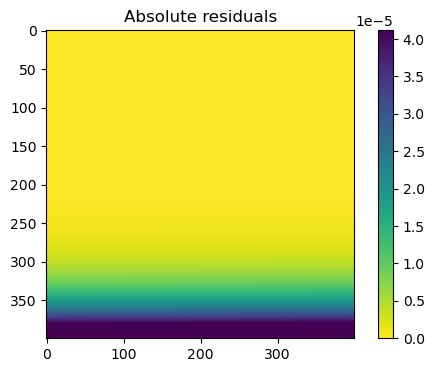

In [16]:
error_heatmap(w_obs, np.zeros_like(M), np.ones_like(M))

In [20]:
#####################
# Define Experiment #
#####################
def run_single_experiment(M_true, k, alpha, prop_obs, max_test_queries, max_calib_queries,
                          r,scale, random_state=0):
    res = pd.DataFrame({})


    #--------Observation bias-------#
    #-------------------------------#
    n1, n2 = M_true.shape
    bm = SamplingBias(n1,n2)
    w_obs = bm.inc_weights(scale = scale,logistic=True)

    #-------Generate masks----------#
    #-------------------------------#
    sampler = QuerySampling(n1,n2)
    mask_obs, mask_test = sampler.sample_submask(sub_size=prop_obs, w=w_obs, random_state=random_state)
    n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)

    print(f"Estimating missingness with guessed rank {r}...")
    w_obs_est = estimate_P(mask_obs, 1, r=r, const=5)
    print("Done estimating!\n")
    sys.stdout.flush()
    
    #------Sample test queries------#
    #-------------------------------#
    n_test_queries = min(int(0.99 * np.sum(np.sum(mask_test, axis=1) // k)), max_test_queries)
    _, idxs_test, _ = sampler.sample_train_calib(mask_test, k, calib_size=n_test_queries, random_state=random_state)  
    if verbose:
        print("Training size:{}, calib size: {}, test size: {}\n".format(np.sum(mask_obs)-n_calib_queries*k, n_calib_queries, n_test_queries))
        sys.stdout.flush()


    #------Split train calib--------#
    #-------------------------------#
    mask_train, idxs_calib, _ = sampler.sample_train_calib(mask_obs, k, 
                                calib_size=n_calib_queries, random_state=random_state)

    #--------Model Training---------#
    #-------------------------------#
    print("Running matrix completion algorithm on the splitted training set...")
    sys.stdout.flush()
    if solver == "pmf":
        Mhat, _, _ = pmf_solve(M, mask_train, k=r, max_iteration=50, verbose=verbose, random_state=random_state)
    elif solver == "svt":
        Mhat = svt_solve(M, mask_train, verbose = verbose, random_state = random_state)
    print("Done training!\n")
    sys.stdout.flush()


    #------Compute intervals--------# 
    #-------------------------------#

    # Evaluate the CI and quantile inflation weights using oracle obs sampling weights
    ci_method = SimulCI(M, Mhat, mask_obs, idxs_calib, k, w_obs=w_obs)
    df = ci_method.get_CI(idxs_test, alpha, allow_inf=allow_inf, store_weights=True)
    lower, upper, is_inf= df.loc[0].lower, df.loc[0].upper, df.loc[0].is_inf
    res = pd.concat([res, evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method="conformal")])

    # Evaluate the CI and quantile inflation weights using estimated obs sampling weights
    ci_est = SimulCI(M, Mhat, mask_obs, idxs_calib, k, w_obs=w_obs_est)
    df = ci_est.get_CI(idxs_test, alpha, allow_inf=allow_inf, store_weights=True)
    lower, upper, is_inf= df.loc[0].lower, df.loc[0].upper, df.loc[0].is_inf
    res = pd.concat([res, evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method="est")])

    # Evaluate the estimation gap
    weights_list = ci_method.weights_list
    est_weights_list = ci_est.weights_list
    est_gaps =[0.5*np.sum(np.abs(weights_list[i]-est_weights_list[i])) for i in range(len(weights_list))]
    avg_gap = np.mean(est_gaps)


    res['k'] = k 
    res['avg_gap'] = avg_gap   
    res['Calib_queries'] = n_calib_queries
    res['Train_entries'] = np.sum(mask_train)
    res['Test_queries'] = n_test_queries
    res['random_state'] = random_state
    return res

In [21]:
#####################
#  Run Experiments  #
#####################
results = pd.DataFrame({})

for i in tqdm(range(1, repetition+1), desc="Repetitions", leave=True, position=0):
    random_state = repetition * (seed-1) + i
    
    for k in tqdm(k_list, desc="k", leave=True, position=0):

        res = run_single_experiment(M, k, alpha, prop_obs, max_test_queries, max_calib_queries,
                            r, scale=scale, random_state=random_state)
        
        results = pd.concat([results, res])

k:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Estimating missingness with guessed rank 20...
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
iter: 20
iter: 21
iter: 22
iter: 23
iter: 24
iter: 25
iter: 26
iter: 27
iter: 28
iter: 29
iter: 30
iter: 31
iter: 32
iter: 33
iter: 34
Function value changing by less than progTol
Done estimating!

Training size:38000, calib size: 2000, test size: 100

Running matrix completion algorithm on the splitted training set...
Iteration: 1; Mean diff: 0.0169
Iteration: 2; Mean diff: 0.0116
Iteration: 3; Mean diff: 0.0035
Iteration: 4; Mean diff: 0.0009
Iteration: 5; Mean diff: 0.0003
Iteration: 6; Mean diff: 0.0002
Iteration: 7; Mean diff: 0.0001
Iteration: 8; Mean diff: 0.0001
Iteration: 9; Mean diff: 0.0001
Iteration: 10; Mean diff: 0.0000
Iteration: 11; Mean diff: 0.0000
Iteration: 12; Mean diff: 0.0000
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Me

CI: 100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.39it/s]

Done!
Computing conformal prediction intervals for 100 test queries...



CI: 100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.37it/s]

Done!



Repetitions: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [03:21<00:00, 201.21s/it]


In [22]:
results

,Query_coverage,Coverage,Size,Inf_prop,Method,k,avg_gap,Calib_queries,Train_entries,Test_queries,random_state
0,0.84,0.890,1.677831,0.15,conformal,5,0.645574,2000,38000,100,1
0,0.63,0.696,0.659391,0.07,est,5,0.645574,2000,38000,100,1


In [63]:
600*600/(400*400)

2.25